In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
# !pip install timm

In [3]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import glob
import tensorflow as tf
# import timm
import random
import time
import copy
from operator import itemgetter

from collections import OrderedDict, namedtuple
import joblib

import logging
import sys

import PIL
import cv2
import albumentations as A
import io
import IPython.display as display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.debug.metrics as met
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.utils.utils as xu

import torchvision
# from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection

import warnings
warnings.filterwarnings("ignore");

In [4]:
train_files = glob.glob('../input/tpu-getting-started/*224/train/*.tfrec')
val_files = glob.glob('../input/tpu-getting-started/*224/val/*.tfrec')
test_files = glob.glob('../input/tpu-getting-started/*224/test/*.tfrec')

In [5]:
def parse_tfrec_data(files, test=False):
    if not test: 
        feature_description = {
            'class': tf.io.FixedLenFeature([], tf.int64),
            'id': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string),
        }
    else:
        feature_description = {
        'id': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parse_image_f = lambda x: tf.io.parse_single_example(x, feature_description)

    ids = []
    images = []
    if not test:
        cl = []

    for i in tqdm(files):
        image_dataset = tf.data.TFRecordDataset(i)
        image_dataset = image_dataset.map(parse_image_f)

        ids_ = [str(id_features['id'].numpy())[2:-1] for id_features in image_dataset] # [2:-1] is done to remove b' from 1st and 'from last in train id names
        ids = ids + ids_

        images_ = [image_features['image'].numpy() for image_features in image_dataset]
        images = images + images_

        if not test:
                cl_ = [int(class_features['class'].numpy()) for class_features in image_dataset]
                cl = cl + cl_
    if test:
        return ids, images
    else:
        return ids, cl, images

In [6]:
train_ids, train_cl, train_images = parse_tfrec_data(train_files)
val_ids, val_cl, val_images = parse_tfrec_data(val_files)
test_ids, test_images = parse_tfrec_data(test_files, test=True)



100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


In [7]:
#add more samples to the train dataset from the eval dataset
train_ids, train_cl, train_images = train_ids + val_ids[:1500], train_cl + val_cl[:1500], train_images + val_images[:1500]
val_ids, val_cl, val_images = val_ids[1500:], val_cl[1500:], val_images[1500:]

In [8]:
print(f'''# train images: {len(train_ids)}
# val images: {len(val_ids)}
# test images {len(test_ids)}''' )

# train images: 14253
# val images: 2212
# test images 7382


3fc7ecd2e
70


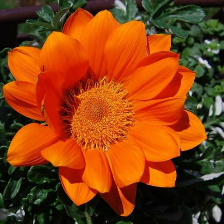

In [9]:
print(train_ids[0])
print(train_cl[0])
sample_img = PIL.Image.open(io.BytesIO(train_images[0]))
sample_img

In [10]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [11]:
class FlowerDataset(Dataset):
    
    def __init__(self, ids, images, cl, transforms, test=False):
        
        self.ids = ids
        self.images = images
        if not test:
            self.cl = cl
        self.transforms = transforms
        self.is_test = test
    
    def __len__(self):
        return len(self.ids)
        
    def __getitem__(self, idx):
        
        img = self.images[idx]
        img = PIL.Image.open(io.BytesIO(img))
        img = np.array(img)
        img = self.transforms(image=img)['image']
        
        if self.is_test:
            return img, -1, self.ids[idx]
        return img, int(self.cl[idx]), self.ids[idx]
     

In [12]:
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.ShiftScaleRotate(p=0.1),
                           A.OneOf([A.RandomShadow(p=1.), A.RandomSunFlare(src_radius=100, p=1.),], p=0.25),
                            A.RandomFog(p=0.1),
                              A.Blur(blur_limit=3, p=0.2),
                           A.GaussNoise(var_limit=200. ,p=0.1),
                           A.RandomBrightness(limit=0.2, p=0.1),
                           A.CLAHE(clip_limit=3, p=0.1),
                            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                           ToTensorV2()
                              
    ])

val_transforms = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2() ])
test_transforms = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])

In [13]:
train_dataset = FlowerDataset(train_ids, train_images, train_cl, transforms=train_transforms)
val_dataset = FlowerDataset(val_ids, val_images, val_cl, transforms=val_transforms)
test_dataset = FlowerDataset(test_ids, test_images, None, transforms=test_transforms, test=True)

train_loader = DataLoader(train_dataset, batch_size=50, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=50, num_workers=4,  shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=50, num_workers=4,  shuffle=True, pin_memory=True)

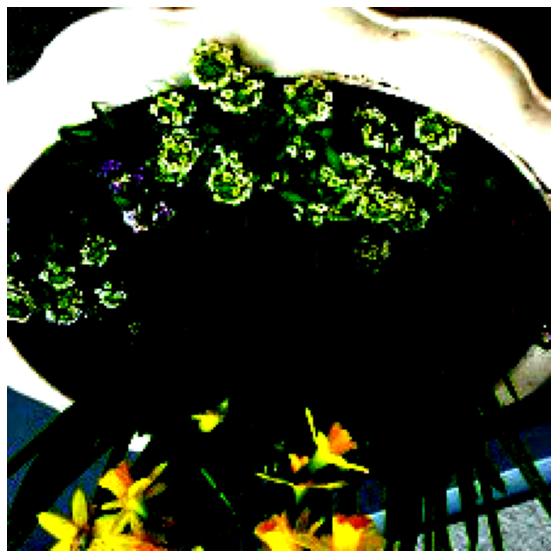

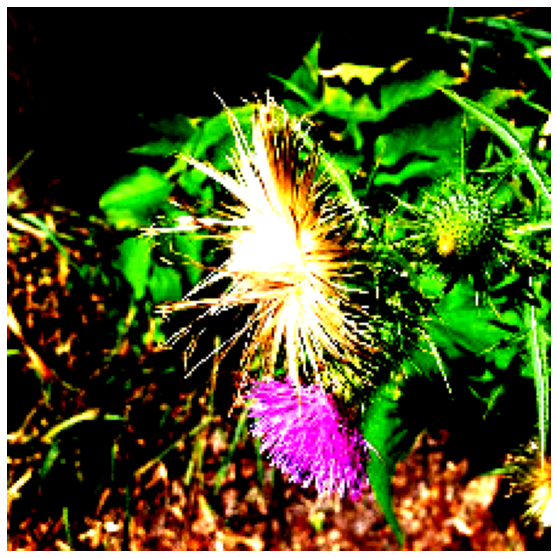

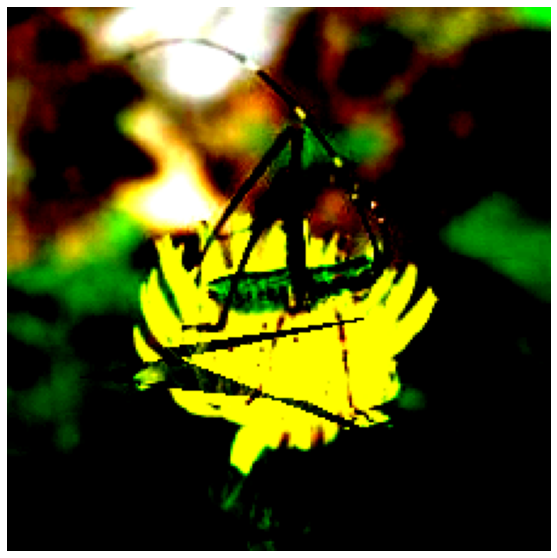

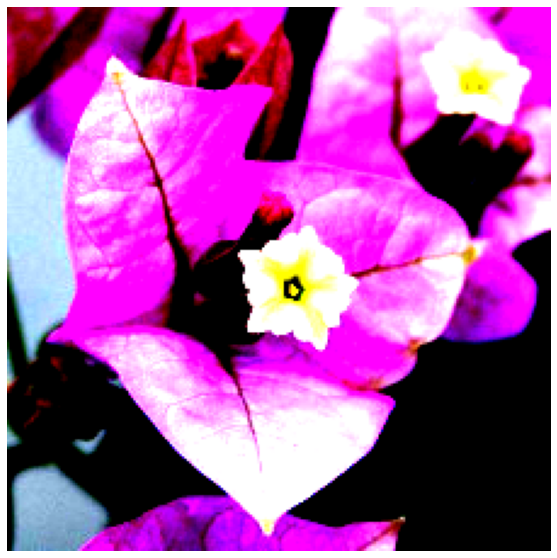

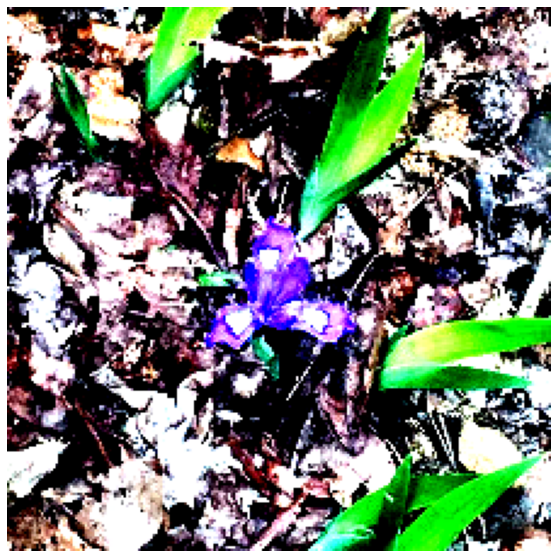

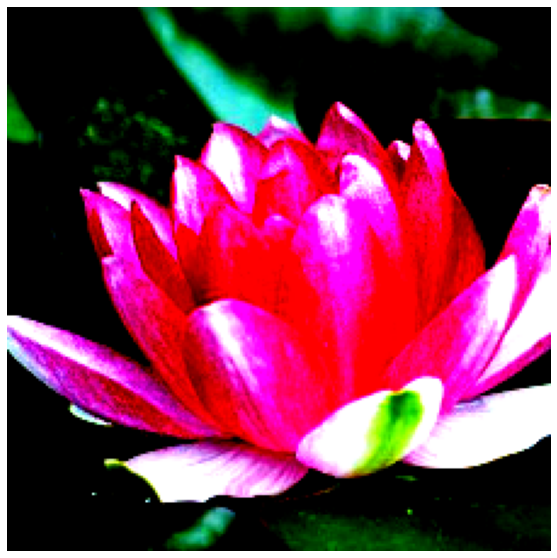

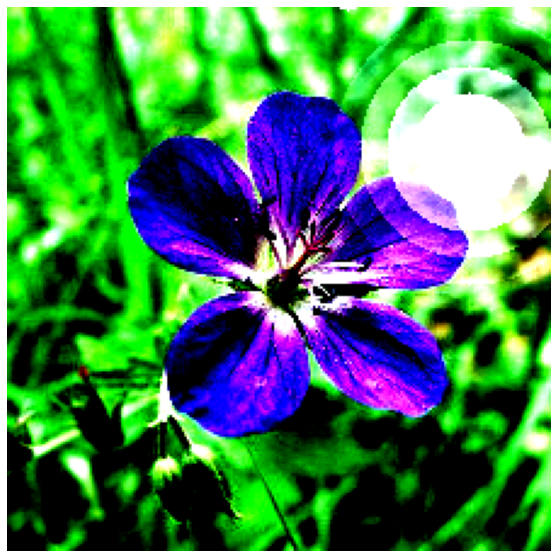

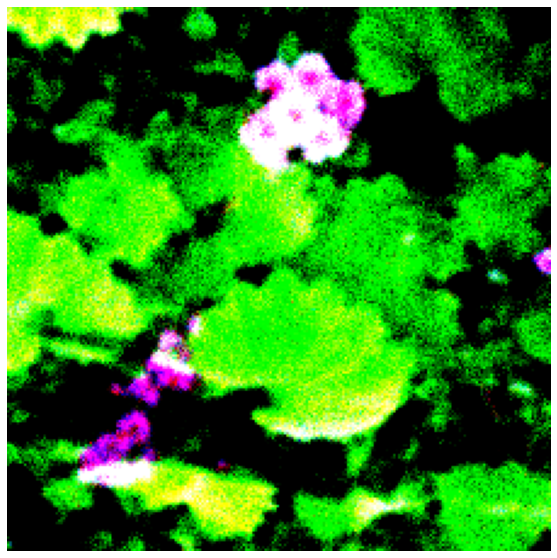

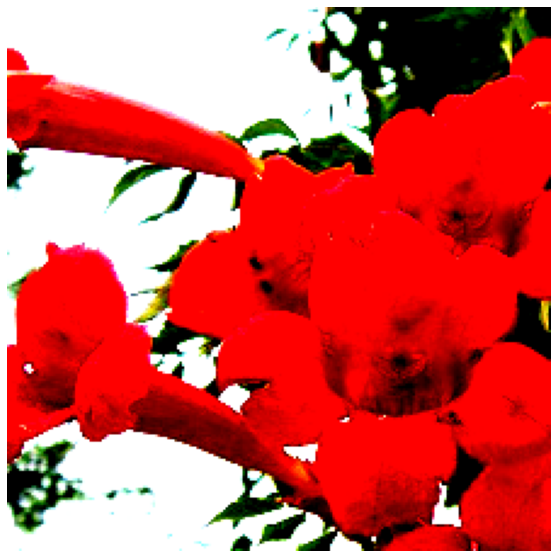

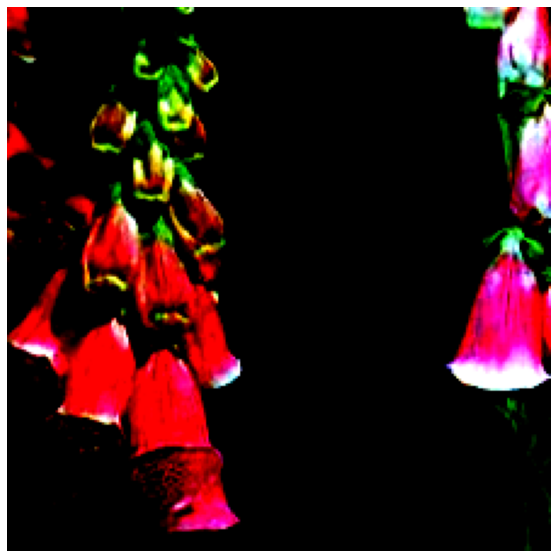

In [14]:
train_iter = iter(train_loader)
img = next(train_iter)
for img2show in img[0][:10].permute(0, 2, 3, 1):
    visualize(img2show.numpy())

In [15]:
model = torchvision.models.resnet50(pretrained=True)
# I would like to download pretrained model, but pytorch has some problems with that now
# profs = 'https://forums.fast.ai/t/lesson1-resnet50-error-certificate-verify-failed/63359/4'

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
for n, p in model.named_parameters():
    if n.split('.')[0] not in ['layer4']:
        p.requires_grad = False
model.fc = nn.Linear(2048, 104)

In [17]:
for k, p in model.named_parameters():
    if p.requires_grad:
        print(k)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [18]:
smpl_input = torch.ones(1, 3, 224, 224)
out = model(smpl_input)
out.shape

torch.Size([1, 104])

In [19]:
def eval_model(model, criterion, test_loader, cuda=True):
    

    model = model.cuda()
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels, _ in test_loader:
        

        batch = batch.cuda()
        labels = labels.cuda()
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy

def train_model(n_epochs, model, optimizer, scheduler, criterion, train_loader, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        step = 0
        for batch, labels, _ in train_loader:
            #if(step % 10 == 0):
                #print(f'the number of step is {step}')
            step += 1
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
            
            
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_loader, cuda=cuda)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        if scheduler is not None:
            scheduler.step(t_loss.data.cpu())
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc 


In [20]:
def plot_learning_curve(train_loss, train_acc, test_loss, test_acc, figsize=(12,6)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.plot(train_loss, marker='.')
    ax1.plot(test_loss, marker='.')
    ax1.legend(['train', 'test'])
    ax1.set_title('Loss')
    ax2.plot(train_acc, marker='.')
    ax2.plot(test_acc, marker='.')
    ax2.legend(['train', 'test'])
    ax2.set_title('Accuracy')

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss()

In [22]:
model, train_loss, train_acc, test_loss, test_acc = train_model(40, model, optimizer, scheduler, criterion, train_loader, val_loader, cuda=True)

EPOCH 0 (98.8755 s.): train loss - 0.037128325551748276, train accuracy - 0.5407984284010384; test loss - 0.018831666558980942, test accuracy - 0.7726039783001808
EPOCH 1 (96.137 s.): train loss - 0.02189188450574875, train accuracy - 0.7015365186276573; test loss - 0.018046870827674866, test accuracy - 0.7622061482820977
EPOCH 2 (97.0795 s.): train loss - 0.014288638718426228, train accuracy - 0.8032694871255175; test loss - 0.013119826093316078, test accuracy - 0.8286618444846293
EPOCH 3 (97.3468 s.): train loss - 0.011250159703195095, train accuracy - 0.8414368904791973; test loss - 0.012047961354255676, test accuracy - 0.8372513562386981
EPOCH 4 (97.4333 s.): train loss - 0.009389332495629787, train accuracy - 0.8673261769452045; test loss - 0.011453703045845032, test accuracy - 0.8503616636528029
EPOCH 5 (97.1695 s.): train loss - 0.007785774767398834, train accuracy - 0.88872518066372; test loss - 0.01211306732147932, test accuracy - 0.8417721518987342
EPOCH 6 (97.3602 s.): train

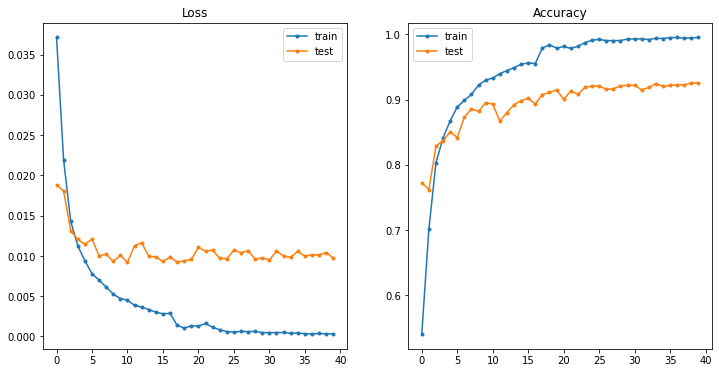

In [23]:
plot_learning_curve(train_loss, train_acc, test_loss, test_acc)

In [24]:
def make_submission(model, test_loader, cuda=True):

    results=[]
    for batch, _, ids in tqdm(test_loader):
        with torch.no_grad():
            if cuda:
                batch = batch.cuda()
            model.eval()
            out = model(batch)
            pred_labels = torch.argmax(out.data.cpu(), dim=1)
            rows = list(
                zip(
                    list(ids), list(pred_labels.numpy().tolist())
                )
            )
            results.append(pd.DataFrame(rows, columns=['id', 'label']))
    result_df = pd.concat(results)
    result_df['label'] = result_df['label'].astype(int)
    return result_df


In [25]:
submission = make_submission(model, test_loader)

100%|██████████| 148/148 [00:31<00:00,  4.71it/s]


In [26]:
submission.to_csv('submission.csv', index=False)